In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

In [3]:
device

device(type='cuda')

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = datasets.CIFAR10(root = './data',
                                train = True,
                                download = True,
                                transform = transform)
    trainloader = torch.utils.data.DataLoader(trainset,
                                               batch_size = batch_size,
                                               shuffle = True,
                                               num_workers = 2)
    testset = datasets.CIFAR10(root = './data',
                               train = False, 
                               download = True,
                               transform = transform)
    testloader = torch.utils.data.DataLoader(testset,
                                             batch_size = batch_size,
                                             shuffle = True,
                                             num_workers = 2)

    return trainloader, testloader

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 8,
                               kernel_size = 3)
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(in_channels = 8,
                               out_channels = 16,
                               kernel_size = 3)
        self.bn2 = nn.BatchNorm2d(16)

        self.act = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size = 2,
                                 stride = 2)
        
        self.fc1 = nn.Linear(16 * 6 * 6, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        
        x = self.bn1(self.pool(self.act(self.conv1(x))))
        x = self.bn2(self.pool(self.act(self.conv2(x))))
        
        x = x.view(x.shape[0], -1)
        
        x = self.bn3(self.act(self.fc1(x)))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [13]:
def fit(epochs, model, criterion, optimizer, trainloader, testloader, lr_sched = None):
    
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    for epoch in tqdm(range(epochs)):


        model.train()
        
        loss_train_sum = 0
        
        for X_batch, y_batch in tqdm(trainloader):
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            output = model(X_batch)
            
            loss = criterion(output, y_batch)
            loss_train_sum += loss.item()

            loss.backward()

            optimizer.step()

            optimizer.zero_grad()

        train_losses.append(loss_train_sum / len(trainloader))
        
        loss_train_sum = 0
        

        model.eval()
        
        loss_test_sum = 0
        correct = 0
        num = 0

        with torch.no_grad():
            for X_batch, y_batch in tqdm(testloader):

                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                probability = model(X_batch)

                loss = criterion(probability, y_batch)
                loss_test_sum += loss.item()

                _, preds = torch.max(probability, axis = 1)

                correct += (preds == y_batch).sum().item()

                num += len(X_batch)

        test_losses.append(loss_test_sum / len(testloader))

        test_accuracies.append(correct / num)

        print('Train losses: ', train_losses[-1])
        print('Test losses: ', test_losses[-1])
        print('Test accuracy: ', test_accuracies[-1])
        
        if lr_sched is not None:
            lr_sched.step()

    return train_losses, test_losses, test_accuracies

In [15]:
def plot_training(train_losses, test_losses, test_accuracies):
    plt.figure(figsize = (12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_losses, label = 'train_losses')
    plt.plot(test_losses, label = 'test_losses')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel('epoch')
    plt.plot(test_accuracies, label = 'test_accuracies')
    plt.legend()

In [17]:
net = Net().to(device) 

In [18]:
criterion = nn.CrossEntropyLoss()

In [21]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, betas = (0.9, 0.999), weight_decay = 0.01)

In [23]:
lr_sched = optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = 0.5)

In [25]:
info = fit(100, net, criterion, optimizer, *get_dataloaders(16), lr_sched)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  1.4439731123542785
Test losses:  1.2466469506263733
Test accuracy:  0.5635


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  1.2070087804985046
Test losses:  1.114944418811798
Test accuracy:  0.6178


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  1.102379742383957
Test losses:  1.029209517812729
Test accuracy:  0.6514


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  1.0294403411102295
Test losses:  0.9943266470432282
Test accuracy:  0.6622


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9763119073581695
Test losses:  0.971311463689804
Test accuracy:  0.6692


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9436922328948975
Test losses:  0.9564141714096069
Test accuracy:  0.675


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9275833893585205
Test losses:  0.9562844787120819
Test accuracy:  0.6786


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9171783262634278
Test losses:  0.9489833296775818
Test accuracy:  0.6794


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9108068976020813
Test losses:  0.9551033642292023
Test accuracy:  0.6768


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9117337050628662
Test losses:  0.9480181027889252
Test accuracy:  0.6816


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.90791123544693
Test losses:  0.9503105681419373
Test accuracy:  0.6808


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9064365050029755
Test losses:  0.9488741051197052
Test accuracy:  0.6792


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9078858173942566
Test losses:  0.9528208742141724
Test accuracy:  0.6785


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9045940491104126
Test losses:  0.9555510268211365
Test accuracy:  0.675


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9094268103218078
Test losses:  0.9522163177013397
Test accuracy:  0.6793


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9055075375461579
Test losses:  0.9508170830249787
Test accuracy:  0.6806


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9028951035690308
Test losses:  0.9518461820602417
Test accuracy:  0.6788


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9072990993404388
Test losses:  0.9471066140174865
Test accuracy:  0.6808


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9101502118778229
Test losses:  0.9457908621788025
Test accuracy:  0.6797


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9061982384395599
Test losses:  0.9511594788551331
Test accuracy:  0.6801


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9079975650024414
Test losses:  0.9527268946170807
Test accuracy:  0.6779


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9062542802429199
Test losses:  0.9486193834304809
Test accuracy:  0.6781


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.906994972076416
Test losses:  0.9522168568611145
Test accuracy:  0.6786


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.909805816450119
Test losses:  0.9481891516685486
Test accuracy:  0.6802


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.905152278470993
Test losses:  0.9459508730888366
Test accuracy:  0.6802


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9049502266979218
Test losses:  0.9573928175449371
Test accuracy:  0.674


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9087077902126313
Test losses:  0.9490186044692993
Test accuracy:  0.6797


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9063691219329834
Test losses:  0.9485504587650299
Test accuracy:  0.6785


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9042021337032318
Test losses:  0.959406301355362
Test accuracy:  0.6782


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9082556288909912
Test losses:  0.9538301166057587
Test accuracy:  0.6768


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9078122569274902
Test losses:  0.9505127676010132
Test accuracy:  0.6787


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9087591174411773
Test losses:  0.9487683817386627
Test accuracy:  0.6783


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9084161135387421
Test losses:  0.9477114127635956
Test accuracy:  0.6808


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9047955811119079
Test losses:  0.9496169390201569
Test accuracy:  0.6807


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.905951215019226
Test losses:  0.9554543717384338
Test accuracy:  0.6769


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9093381103420257
Test losses:  0.9515175021648407
Test accuracy:  0.6779


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9054721797275543
Test losses:  0.9477863101482391
Test accuracy:  0.6825


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9055551602268219
Test losses:  0.9476048079967498
Test accuracy:  0.6824


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9078985762882232
Test losses:  0.952420188331604
Test accuracy:  0.6783


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9054260896778107
Test losses:  0.9517762099266053
Test accuracy:  0.6765


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9085257167243957
Test losses:  0.9472871623516083
Test accuracy:  0.6797


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.905869754447937
Test losses:  0.9500933181762695
Test accuracy:  0.6797


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9039245896434784
Test losses:  0.945890115070343
Test accuracy:  0.6794


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9057710693359375
Test losses:  0.9490322990894318
Test accuracy:  0.6794


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9075122575855256
Test losses:  0.9510245186328888
Test accuracy:  0.6795


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9034748194408416
Test losses:  0.9478989183425903
Test accuracy:  0.6802


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9084315007114411
Test losses:  0.9486490136623382
Test accuracy:  0.6792


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9053862893104553
Test losses:  0.9479143986225128
Test accuracy:  0.6794


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9053200772190094
Test losses:  0.9479844525337219
Test accuracy:  0.6809


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9055548096370697
Test losses:  0.9482854313850403
Test accuracy:  0.6818


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9111213896846772
Test losses:  0.9465014979600906
Test accuracy:  0.6812


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9045512482357025
Test losses:  0.9545436884880066
Test accuracy:  0.6781


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9058123648643494
Test losses:  0.9528299512863159
Test accuracy:  0.6777


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9098547899436951
Test losses:  0.9434682017803192
Test accuracy:  0.6813


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9052296531295776
Test losses:  0.9492315407276154
Test accuracy:  0.6781


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9082566244411469
Test losses:  0.9509114419937134
Test accuracy:  0.6821


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9069898374938965
Test losses:  0.9487724992752076
Test accuracy:  0.6787


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9056162083435059
Test losses:  0.9575378161907196
Test accuracy:  0.6731


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9084956990051269
Test losses:  0.9475090517044067
Test accuracy:  0.6791


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9096438248634339
Test losses:  0.9483743470191955
Test accuracy:  0.6821


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.90017021068573
Test losses:  0.9522456365585327
Test accuracy:  0.6739


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9024460677433014
Test losses:  0.9489047654151916
Test accuracy:  0.6819


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9052030315303803
Test losses:  0.9506867680549621
Test accuracy:  0.6808


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9073367268753052
Test losses:  0.9450648858070374
Test accuracy:  0.6818


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9072055773448944
Test losses:  0.9490279101848602
Test accuracy:  0.6789


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9074025695610046
Test losses:  0.9500570414066315
Test accuracy:  0.6798


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9048965037727356
Test losses:  0.9546569431781768
Test accuracy:  0.6779


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9047594829368591
Test losses:  0.9493517054557801
Test accuracy:  0.677


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9075742162895203
Test losses:  0.94759538397789
Test accuracy:  0.679


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9025643701267242
Test losses:  0.9554535122394562
Test accuracy:  0.6781


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9053190056228637
Test losses:  0.9547142290115357
Test accuracy:  0.6768


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9037047603511811
Test losses:  0.95686984000206
Test accuracy:  0.6769


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9058894968891144
Test losses:  0.9465844267368316
Test accuracy:  0.679


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9057131482696533
Test losses:  0.9488325742244721
Test accuracy:  0.6808


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9041494031238556
Test losses:  0.9470112315654755
Test accuracy:  0.6798


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9068884507751465
Test losses:  0.9500818123817444
Test accuracy:  0.6824


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9105524807929992
Test losses:  0.9554762201309204
Test accuracy:  0.6763


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.908343101940155
Test losses:  0.9553563236713409
Test accuracy:  0.6766


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.907464841890335
Test losses:  0.9454688423156739
Test accuracy:  0.6833


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9101834719371795
Test losses:  0.9555094862937927
Test accuracy:  0.6775


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.906754663772583
Test losses:  0.949241851568222
Test accuracy:  0.682


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9056483210086822
Test losses:  0.9528466419696808
Test accuracy:  0.6775


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9060608658409118
Test losses:  0.9488784790039062
Test accuracy:  0.6818


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9030704160308838
Test losses:  0.948549132156372
Test accuracy:  0.6787


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.91002851978302
Test losses:  0.9477446860313415
Test accuracy:  0.6827


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9052402842998505
Test losses:  0.9463729749679566
Test accuracy:  0.6801


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9075212646389007
Test losses:  0.9519914180755615
Test accuracy:  0.6808


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9058887278175354
Test losses:  0.9477856355667115
Test accuracy:  0.6806


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9040942432022094
Test losses:  0.9457566243171692
Test accuracy:  0.6797


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9051293518066407
Test losses:  0.9552614834785461
Test accuracy:  0.6804


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9080974550247193
Test losses:  0.9514844308376312
Test accuracy:  0.6792


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9086906987857819
Test losses:  0.9529115230083466
Test accuracy:  0.676


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9086520283985138
Test losses:  0.9465789965629577
Test accuracy:  0.6789


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9059547742462158
Test losses:  0.9469783555984497
Test accuracy:  0.6831


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9056183096599579
Test losses:  0.9448124178886413
Test accuracy:  0.6802


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9053334429073334
Test losses:  0.9475062835216522
Test accuracy:  0.6818


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9063493384361268
Test losses:  0.9489941349506378
Test accuracy:  0.6801


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9043758026218415
Test losses:  0.9495538432598114
Test accuracy:  0.6797


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9077237739276885
Test losses:  0.946513150024414
Test accuracy:  0.6813


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train losses:  0.9035684607315063
Test losses:  0.9542287137031555
Test accuracy:  0.6786


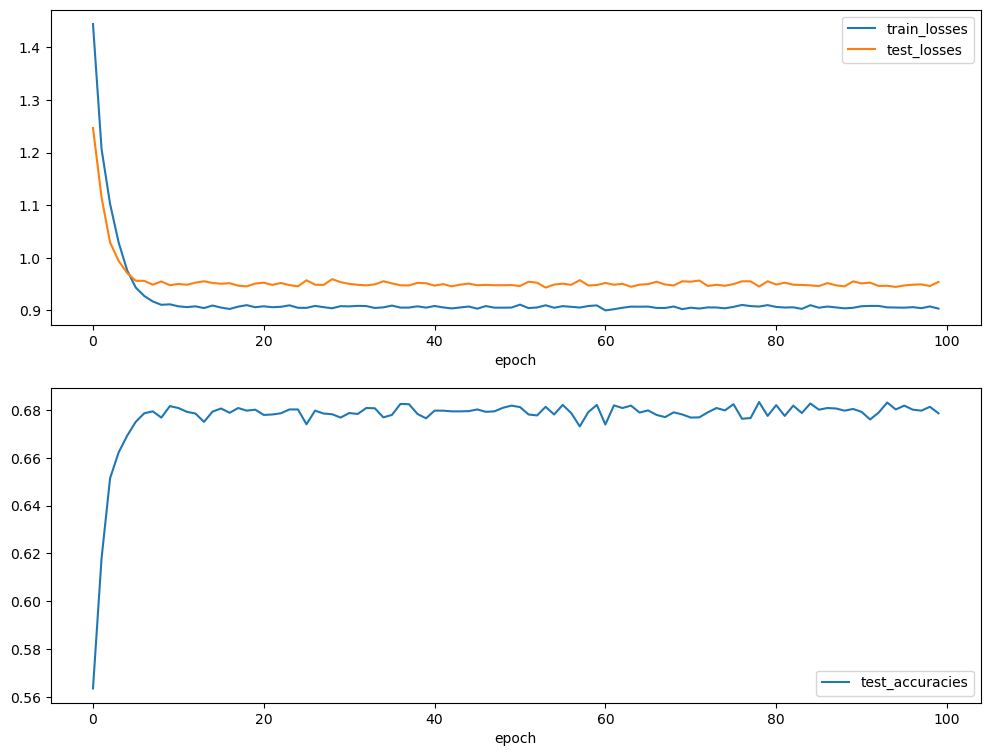

In [27]:
plot_training(*info)